In [3]:
%matplotlib inline
#format the book
import book_format
book_format.set_style()

# 简介

# 牛顿运动定律
在前面的案例中,我们假设小车运动是匀速直线运动,那么我们可以根据速度$v$推测出小车经过$t$秒之后的位置$x$
$$x = vt + x_0$$

在上面的基础上,我们可以增加恒定的加速度$a$,那么公式可以整理为:
$$x = \frac{1}{2}at^2 + v_0t + x_0$$

# 卡尔曼滤波算法

在前面的章节中,我们学习过卡尔曼滤波算法的步骤:

1. 初始化
    - 初始化状态
    - 初始化方差
2. 预测
    - 使用运动模型进行预测
3. 更新
    - 获取测量的均值和方差
    - 获取预测的均值和方差
    - 计算卡尔曼增益
    - 将测量的结果与预测的结果高斯相乘
    - 更新预测的方差

<u>**预测**</u>

$\begin{array}{|l|l|l|}
\hline
\text{一维} & \text{一维} & \text{多维}\\
& \text{卡尔曼格式)} & \\
\hline
\bar \mu = \mu + \mu_{f_x} & \bar x = x + dx & \bar{\mathbf x} = \mathbf{Fx} + \mathbf{Bu}\\
\bar\sigma^2 = \sigma_x^2 + \sigma_{f_x}^2 & \bar P = P + Q & \bar{\mathbf P} = \mathbf{FPF}^\mathsf T + \mathbf Q \\
\hline
\end{array}$

参数说明:

$\mathbf x,\, \mathbf P$ 状态均值,协方差. 他们等同于一维中的 $x$ 和 $\sigma^2$.

$\mathbf F$ 状态转移函数.它与$\bf x$ 相乘,计算出预测的状态. 

$\mathbf Q$ 过程协方差. 

$\mathbf B$ and $\mathbf u$  它是系统的外部输入.

<u>**更新**</u>

$\begin{array}{|l|l|l|}
\hline
\text{一维} & \text{一维} & \text{多维}\\
& \text{( 卡尔曼格式)} & \\
\hline
& y = z - \bar x & \mathbf y = \mathbf z - \mathbf{H\bar x} \\
& K = \frac{\bar P}{\bar P+R}&
\mathbf K = \mathbf{\bar{P}H}^\mathsf T (\mathbf{H\bar{P}H}^\mathsf T + \mathbf R)^{-1} \\
\mu=\frac{\bar\sigma^2\, \mu_z + \sigma_z^2 \, \bar\mu} {\bar\sigma^2 + \sigma_z^2} & x = \bar x + Ky & \mathbf x = \bar{\mathbf x} + \mathbf{Ky} \\
\sigma^2 = \frac{\sigma_1^2\sigma_2^2}{\sigma_1^2+\sigma_2^2} & P = (1-K)\bar P &
\mathbf P = (\mathbf I - \mathbf{KH})\mathbf{\bar{P}} \\
\hline
\end{array}$

$\mathbf H$是测量函数,负责将测量矩阵转成和状态矩阵格式一致  
$\mathbf z,R$ 分别为测量的均值与测量噪声协方差,它等同于我们前面讲的测量值$z$和测量的方差$\sigma_z^2$  
$y$和$K$分别为计算结果和卡尔曼增益

其中状态相关的($\mathbf x$,$P$),过程相关的($F$,$Q$),测量相关的($\mathbf z$,$R$),还有测量函数$H$都是需要我们自己定义的,如果系统还有外部控制,我们还需要定义$\mathbf B$和$\mathbf u$

在`filter.py.kalman`中已经实现了`predict`和`update`,这可以让我们很方便的去使用卡尔曼滤波

# 跟踪小车
我们继续跟踪小车,这一次我们要用到隐藏的没有测量的数据来提高我们预测的精度

我们先来准备一些模拟数据,我们先准备一些过程噪声process_var,再准备一些测量噪声z_var,然后我们创建了下面这样的函数

In [4]:
import math
import numpy as np
from numpy.random import randn

def compute_car_data(z_var,process_var,count,dt=1):
    x,vel = 0.,1.
    # 测量的标准差
    z_std = math.sqrt(z_var)
    # 运动过程的标准差
    p_std = math.sqrt(process_var)
    # 存储真实值, 测量值
    xs,zs = [],[]
    
    for _ in range(count):
        # 真实值, 速度可能会因为上坡,下坡,风影响,所以加上过程噪声
        v = vel + (randn()*p_std)
        x += v*dt
        # 真实值
        xs.append(x)
        # 测量的设备也会因为一些影响而差生误差
        zs.append(x + randn()* z_std)
        
    return np.array(xs),np.array(zs)    

compute_car_data(1,1,10,1)

(array([1.346, 1.47 , 2.197, 3.277, 3.217, 4.198, 5.32 , 7.771, 8.806,
        9.394]),
 array([2.643, 2.178, 1.746, 2.877, 3.124, 5.361, 5.117, 7.367, 9.594,
        9.04 ]))

## 预测
为了进行预测,我们需要设计状态与协方差,运动模型,过程噪声,外部输入

### 设计状态变量
在一维的卡尔曼滤波中,我们跟踪小车的位置. $\mu$ 表示小车最有可能出现的位置.$\sigma^2$ 表示位置最有可能的分布. 小车的位置就是我们所说的状态,$\mu$就是状态变量

在本章我们将同时跟踪小车的位置和速度,这就需要用到多维高斯模型.
        $$\mu = \begin{bmatrix}10.0\\4.5\end{bmatrix}$$

在很多书里面可能是这样来表述状态的:
$$\mathbf x =\begin{bmatrix}x \\ \dot x\end{bmatrix}$$

其中粗体$\mathbf x$表示状态矩阵,x表示位置,$\dot x$表示对位置进行求导结果为速度


在继续学习之前,我们先来回顾一下矩阵的点乘吧!

In [5]:
A = np.array([[1,2],[3,4]])
x = np.array([[10.],
             [4.5]])

res = np.dot(A,x)
print(res)

[[19.]
 [48.]]


在python3.5之后,这种写法还可以简写成如下形式:

In [6]:
res2 = A@x
print(res2)

[[19.]
 [48.]]


## 设计状态协方差
另外一半状态高斯模型就是协方差矩阵$\mathbf P$. 在一维的卡尔曼滤波中,我们初始化了$\sigma^2$,并且这个值在进行融合的时候还做了更新.  
在多维的卡尔曼滤波中,我们同样需要指定这个$\mathbf P$,并且在滤波的时候需要更新$\mathbf P$

在跟踪小车的过程中,我们先假设位置x和速度vel之间是没有关联关系的,我们可以看看在滤波的过程中会不会发生变化. 我们假设非常不确定小车当前的位置和速度,那么我们可以先指定位置的方差$\sigma_\mathtt{pos}^2 = 500 m^2$, 速度的方差$\sigma_\mathtt{vel}^2=7^2=49$.

所以我们可以写出初始协方差矩阵为:

$$
\mathbf P = \begin{bmatrix}500 & 0 \\ 0&49\end{bmatrix}
$$

我们可以使用`numpy.diag`很方便的在代码中创建一个对角矩阵

In [7]:
P = np.diag([500.,49.])
P

array([[500.,   0.],
       [  0.,  49.]])

当然我们也可以手工自己编写:

In [8]:
P = np.array([[500.,0],
              [0.,49.]])
P

array([[500.,   0.],
       [  0.,  49.]])

# 设计状态矩阵
接下来我们来设计过程模型.对于我们的小车来说,我们先假设小车是做直线匀速运动的,所以小车只有x方向的坐标,速度位vel.   
卡尔曼滤波是根据物体上一刻的状态来预测当前的状态,那么我们的小车的运动模型应该如下:
$$x = v\Delta t + x_0$$

代码实现如下;
```python
  def predict(pos,movement):
    return gaussian(pos.mean + movement.mean,pos.var + movement.var)  
```
本章我们要做的事情,和一维的差不多,只不过是将单个变量换成了矩阵.

$$ \mathbf x = \begin{bmatrix}5.4\\4.2\end{bmatrix}, \, \, 
\dot{\mathbf x} =  \begin{bmatrix}1.1\\0.\end{bmatrix} \\
\mathbf x = \dot{\mathbf x}t + \mathbf x$$

等号左边的$\mathbf x$表示的是根据模型预测出来的结果,等号右边的$\mathbf x$表示的是上一次的结果

在线性代数中,这种运算其实有很多种表达形式,例如下面这两个二元一次方程:
$$\begin{cases}
2x+3y=8\\4x-y=2
\end{cases}$$
我们将它们写成矩阵的形式就是下面这个样子:
$$\begin{bmatrix}2& 3 \\ 4&-1\end{bmatrix} \begin{bmatrix}x\\y\end{bmatrix} = \begin{bmatrix}8\\2\end{bmatrix}$$

这个其实就矩阵的乘法,我们要求解$\mathbf{Ax}=\mathbf B$中的$\mathbf x$

$$\mathbf{A} = \begin{bmatrix}2& 3 \\ 4&-1\end{bmatrix},\, \mathbf x = \begin{bmatrix}x\\y\end{bmatrix}, \mathbf B=\begin{bmatrix}8\\2\end{bmatrix}$$

我们可以使用`scipy.linalg`中的`solve`函数来进行求解

In [9]:
from scipy.linalg import solve
A = np.array([[2, 3],[4, -1]])
b = np.array([[8], [2]])
x = solve(A, b)
x

array([[1.],
       [2.]])

按照上面所讲的这种方式,我们就可以将我们前面推导的公式,改写成矩阵的乘法.我们用$\bar x$来表示当前预测状态,$x$表示上一次的状态,可以写出下面这个公式:
$$\mathbf{\bar x} = \mathbf{Fx}$$

这样我们就可以来预测位置和速度啦!

$$\begin{bmatrix} \bar x \\ \dot{\bar x}\end{bmatrix} = \begin{bmatrix}? & ? \\? & ?\end{bmatrix}\begin{bmatrix}x\\\dot x\end{bmatrix}$$

这里面的这些`?`位置该怎么填写呢? 我们可以先分别来预测位置和速度:

$$\begin{cases}
\begin{aligned}
\bar x &= x + \dot x \Delta t \\
\bar{\dot x} &= \dot x
\end{aligned}
\end{cases}$$

将这个式子稍微整理一下就是:


$$\begin{cases}
\begin{aligned}
\bar x &= 1x + \dot x \Delta t \\
\bar{\dot x} &= 0x + \dot x
\end{aligned}
\end{cases}$$

那么上面的式子写成矩阵的形式就是这样的:


$$\begin{bmatrix} \bar x \\ \dot{\bar x}\end{bmatrix} = \begin{bmatrix}1 & \Delta t \\0 & 1\end{bmatrix}\begin{bmatrix}x\\\dot x\end{bmatrix}$$

简写形式为:
$$\mathbf{\bar x} = \mathbf{Fx}$$

其中$\mathbf F$我们称为状态转移函数,从上一状态转移到当前状态.

接下来,我们用filterpy来测试一下预测:

In [10]:
from filterpy.kalman import predict
import numpy as np
dt = 0.1
x = np.array([10.0,4.5])

P = np.diag([500,49])

F = np.array([[1,dt],[0,1]])

x,P = predict(x=x,P=P,F=F)
print("x=",x)
print("P=",P)

x= [10.45  4.5 ]
P= [[500.49   4.9 ]
 [  4.9   49.  ]]


我们可以再多做几次试验,看看预测的结果:

In [11]:
for _ in range(5):
    x,P = predict(x=x,P=P,F=F)
    print("x=",x)

x= [10.9  4.5]
x= [11.35  4.5 ]
x= [11.8  4.5]
x= [12.25  4.5 ]
x= [12.7  4.5]


`predict()`函数会同时计算根据模型计算的预测结果,同时还会计算P的值

In [12]:
print(P)

[[517.64  29.4 ]
 [ 29.4   49.  ]]


上面的这个对角矩阵结果告诉我们,位置的协方差增大了,并且位置和速度之间是存在关系的.   
至于为什么方差变大了,这个其实很容易想明白.因为小车的位置发生变化了,而小车速度存在误差,所以小车的位置受速度影响方差变大.

下面我们用绘图的方式将预测前后的协方差绘制出来:

x= [11.35  4.5 ]
P= [[545. 150.]
 [150. 500.]]


32

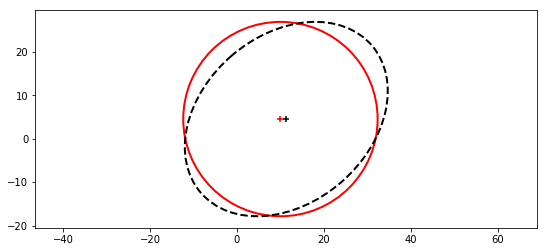

In [13]:
from filterpy.stats import plot_covariance_ellipse

dt = 0.3
F = np.array([[1, dt], [0, 1]])
x = np.array([10.0, 4.5])
P = np.diag([500, 500])
plot_covariance_ellipse(x, P, edgecolor='r')
x, P = predict(x, P, F, Q=0)
plot_covariance_ellipse(x, P, edgecolor='k', ls='dashed')

print("x=",x)
print("P=",P)
256//8

# 过程噪声
在前面的案例中,我们都是假定小车是匀速直线运动,但是在现实世界中,小车很难维持一个匀速运动,比如汽车上坡,溜坡,雨天道路打滑,台风影响等等因素. 为了对模拟这种现实情况,我们引入高斯噪声Q.
例如,我们假定匀速运动速度为0.3m/s,当我们加入过程噪声Q之后,小车的速度在0.3m/s上下一定范围内浮动.

如果是一维卡尔曼滤波那么小车的方差=方差+过程噪声Q,如果是多维的卡尔曼滤波,那么协方差P=P+Q

我们也可以使用filterpy中提供的函数`Q_discrete_white_noise`来生成这种高斯白噪声Q

In [14]:
from filterpy.common import Q_discrete_white_noise
import numpy as np
Q = Q_discrete_white_noise(dim=2,dt=1,var=2.35)

print(Q)
np.set_printoptions(suppress=False,precision=20)
Q = 0.01 ** 2 * np.eye(2)

print(Q)


[[0.588 1.175]
 [1.175 2.35 ]]
[[0.0001 0.    ]
 [0.     0.0001]]


# 控制方程
卡尔曼滤波不仅仅可以过滤数据,它还能将外部的一些控制整合到运算中.例如我们的小车,我们可能不停地修改它的线速度和角速度,卡尔曼滤波可以根据当前的位置,当前速度,以及组合外部输入的影响因素来进行预测!

例如,小车在做直线运动的过程中,遇到了下坡,这时它就受到了重力加速度的影响,存在一个竖直方向的加速度,这个就是外部输入控制.  
我们通常用变量$u$来表示
而我们的状态矩阵可能是`[x,v]`,但是加速度是一个值$g$,我们需要一个控制矩阵$B$,将加速度的形式转成和我们状态矩阵形状相同,以便它能够参与到$\mathbf{\bar x} = \mathbf{Fx} $ 的运算中去.  

所以我们最终我们的公式将写成这样:

$$\mathbf{\bar x} = \mathbf{Fx} + \mathbf{Bu}$$

其中$u$表示外部输入,$B$表示将$u$转成和状态矩阵相同维度的转换矩阵

例如小车做直线运动时的加速度为a,那么我们用矩阵表示u=[a],我们如果想让u的形状和状态矩阵$ \mathbf x = \begin{bmatrix}5.4\\4.2\end{bmatrix}$相同的话,我们需要B矩阵:$ \mathbf x = \begin{bmatrix} \frac {1} {2}t^2 \\t\end{bmatrix}$

至此,我们就完成了状态方程的推导,我们再把他们总结一下.

我们假设了小车做直线加速运动,那么位置的公式为:
$$x = x_0 + v_0t + \frac{1}{2}at^2$$
速度的公式为:  
$$v = v_0t + at$$

我们将上面这两个公式稍作整理:
$$x = 1*x_0 + t*v_0 + \frac{1}{2}t^2*a$$
$$v = 0*x_0 + t*v_0 + t*a$$

然后我们可以将上面的式子改成矩阵的形式:
$$\begin{aligned}
\begin{bmatrix}\bar x \\ \bar{\dot x}\end{bmatrix} &= \begin{bmatrix}1&\Delta t  \\ 0&1\end{bmatrix}  \begin{bmatrix}x \\ \dot x\end{bmatrix}  + \begin{bmatrix}\frac{1}{2}t^2 \\ t\end{bmatrix}\begin{bmatrix} a\end{bmatrix}\\
\mathbf{\bar x} = \mathbf{Fx} + \mathbf{Bu}
\end{aligned}$$

加入小车做的是匀速运动,则小车的B和u都为0,我们可以来进行一下预测

In [15]:
B = 0 
u = 0
x,P = predict(x,P,F,Q,B,u)
print("x=",x)
print("P=",P)

x= [12.7  4.5]
P= [[680.0001 300.    ]
 [300.     500.0001]]


至此,我们已经完成了预测部分的所有内容
x,P : 表示状态和状态协方差矩阵
F,Q : 模型和噪声协方差
B,u : 这个不是必须的,控制方程

## 更新的步骤
下面我们开始来实现一下更新的步骤,在一维卡尔曼中我们计算测量值和预测值的差异:
$$y = z - \bar x$$ 
在多维的卡尔曼滤波中,所有的数据都是矩阵形式,所以它的公式如下:
$$\mathbf y = \mathbf z - \mathbf{H\bar x} $$
那这里出现的H矩阵是干嘛用的呢 ?  
按照前面额示例,我们的状态矩阵为$\mathbf x = \begin{bmatrix}x\\ \dot x\end{bmatrix}$ ,它包含位置和速度,而我们测量的矩阵可能只包含位置$\mathbf z = \begin{bmatrix}z_1\end{bmatrix}$, 很显然x和z没有办法在上面的式子中,直接进行相加,这个时候我们就需要H矩阵将x矩阵转成能与测量矩阵进行运算的格式.  
想上面的这种情况,测量的数据只有**位置**我们可以推算出$H = \begin{bmatrix} 1 & 0\end{bmatrix}$  
假设我们能同时测量**位置**和**速度**,则$H = \begin{bmatrix} 1 & 1\end{bmatrix}$

In [16]:
H = np.array([[1., 0.]])

### 设计测量的协方差
通常我们用R来表示测量噪声. 我们用一把尺子测量同一枚硬币的直径,第一次测量为1.5cm,第二次测量为:1.6cm,第三次测量为:1.4cm. 由于是同一把尺子,对同一个物品进行测量,很显然这之前存在测量误差,我们把这种测量的误差称为噪声.
假设我们用$\sigma$来表示标准差,那么它的方差就是$\sigma^2$,它表示测量的数据有97%的可能落在$3\sigma$范围内
  
我们用$R = \begin{bmatrix} \sigma^2 \end{bmatrix}$来表示测量的噪声,当然这仅仅只是当只测量一种数据的情况下,我们可以这样写.

如果测量的数据是多个,例如我们同时有两个设备对速度和位置分别进行测量,我们假设测量位置的设备方差为5,测量速度的设备方差为3.多个数据我们就需要用协方差矩阵来表示:
$$R = \begin{bmatrix}5&0\\0&3\end{bmatrix}$$


In [17]:
from filterpy.kalman import update
z = 1.
R = np.array([[5]])
x, P = update(x, P, z, R, H)
print('x =', x)

x = [ 1.0854014473866513 -0.6240868431990005]


x =  [[0. 0.]]
R =  [[1.]]
Q = 
 [[1. 0.]
 [0. 1.]]


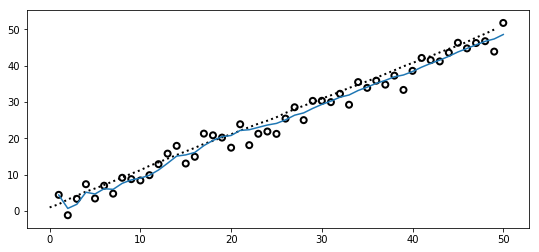

In [19]:
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

car_filter = KalmanFilter(dim_x=2, dim_z=1)
print('x = ', car_filter.x.T)
print('R = ', car_filter.R)
print('Q = \n', car_filter.Q)

dt = 0.1
x = np.array([0,0.])
F = np.array([[1., dt],
               [0.,  1.]]) 
P = np.array([[500,0],
              [0,500]])
Q =  Q_discrete_white_noise(dim=2, dt=dt, var=0.01)

R = np.array([[5.]])
H = np.array([[1.,0]])

car_filter.x = x
car_filter.F = F
car_filter.P = P
car_filter.Q = Q
car_filter.R = R
car_filter.H = H



# 生成模拟数据
actual,zs = compute_car_data(5,0.01,50)



xs, cov = [], []
for z in zs:
    car_filter.predict()
    car_filter.update(z)
    xs.append(car_filter.x)
    cov.append(car_filter.P)

xs, cov = np.array(xs), np.array(cov)



import matplotlib.pyplot as plt
import book_plots as bp
def plot_track(ps,actual,zs,cov):
    count = len(zs)
    bp.plot_track(actual, c='k')
    bp.plot_measurements(range(1, count + 1), zs)
    bp.plot_filter(range(1, count + 1), ps)
    
    plt.show()


plot_track(xs[:, 0], actual, zs, cov)
    
    



In [26]:
dt = 0.1
R_var = 5
Q_var = 0.01
x = np.array([[10.0, 4.5]]).T
P = np.diag([500, 49])
F = np.array([[1, dt],
              [0,  1]])
H = np.array([[1., 0.]])
R = np.array([[R_var]])
Q = Q_discrete_white_noise(dim=2, dt=dt, var=Q_var)

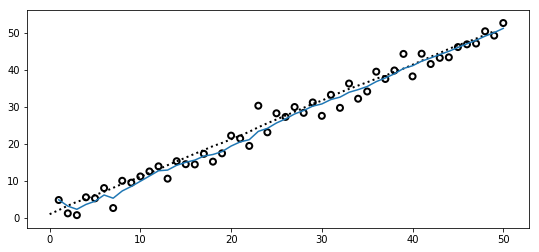

In [27]:
from scipy.linalg import inv

count = 50
track, zs = compute_car_data(R_var, Q_var, count)
xs, cov = [], []
for z in zs:
    # 预测
    x = F @ x
    P = F @ P @ F.T + Q
    
    #更新
    S = H @ P @ H.T + R
    K = P @ H.T @ inv(S)
    y = z - H @ x
    x += K @ y
    P = P - K @ H @ P
    
    xs.append(x)
    cov.append(P)

xs, cov = np.array(xs), np.array(cov)
plot_track(xs[:, 0], track, zs, cov)